In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

import helper_functions
from model_run import *

C:\Users\hanic\AppData\Local\Temp\ipykernel_24244\1147271186.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


A simplifying diagram for how the gravity and Bell models are computed in practice:

<img src="ideas/gravity, bell pipeline.png" width="800"/>

In [2]:
import pickle
with open("networks/Hungary_2022_road_network_connected.pickle", "rb") as f:
    G = pickle.load(f)

ksh_stats = pd.read_csv("data/sources/KSH/KSHSettlList_settlID_settlname_pop_lat_lon.csv")
ksh_flows_16 = pd.read_csv("data/sources/KSH/flows_16_cities.csv")
odm_gravity_df = pd.read_csv("computing/odm/ODM_16_cities_gravity_unfitted_unordered.csv")

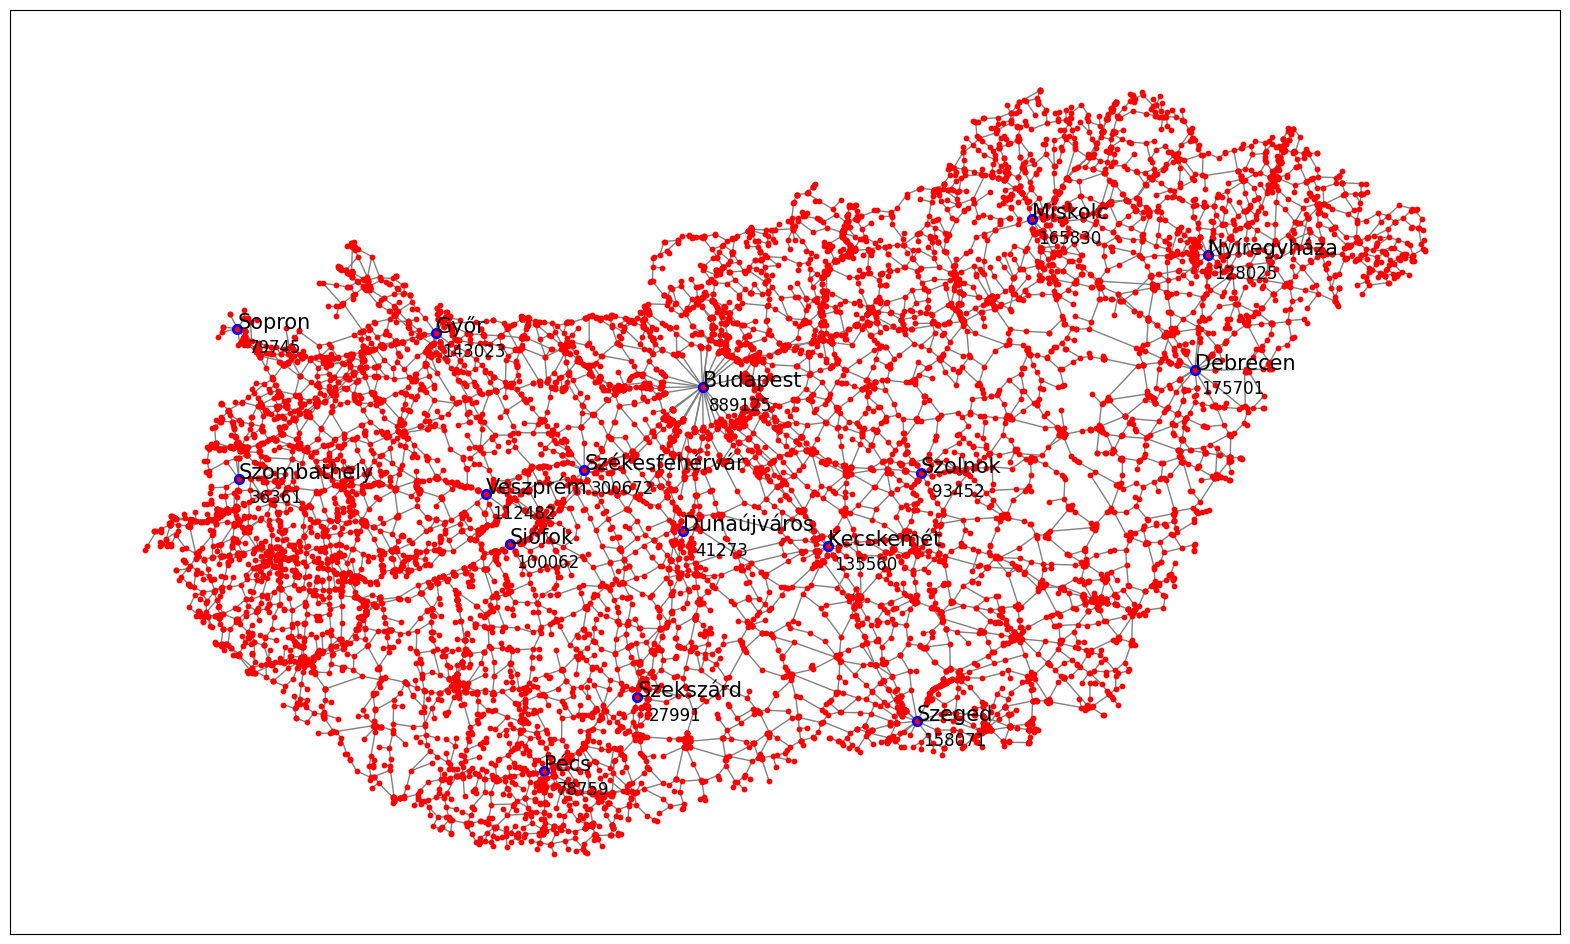

In [3]:
import matplotlib.cm
import matplotlib.colors
color_map = matplotlib.colormaps.get_cmap('prism')
components = nx.connected_components(G)
plt.figure(figsize=(20, 12))
for i, component in enumerate((list(nx.connected_components(G)))):
    subgraph = G.subgraph(component)
    pos = {node: (attrs['x'], attrs['y']) for node, attrs in subgraph.nodes(data=True)}
    nx.draw_networkx(subgraph, pos=pos, node_color=[color_map(i)], with_labels=False, edge_color='gray', node_size=10,)

#Plot the nodes with "name" attribute that have ignore=False
for node, attrs in G.nodes(data=True):
    if not attrs.get('ignore', True):
        # Calculate the sum of the weights of the edges
        edge_weight_sum = sum(data['weight'] for _, _, data in G.edges(node, data=True))
        
        plt.scatter(attrs['x'], attrs['y'], c='blue', s=50)
        plt.text(attrs['x'], attrs['y'], attrs['location_name'], fontsize=15,)
        
        # Display the sum of the weights under the location name
        plt.text(attrs['x']+15000, attrs['y'] - 10000, f'{edge_weight_sum}', fontsize=12, ha='center')
plt.show()

In [4]:
mapping = {attrs['location_name']:node for node, attrs in G.nodes(data=True) if attrs.get('location_name', None) is not None}

#Print these node names
for node, attrs in G.nodes(data=True):
    if not attrs.get('ignore', True):
        print(attrs['location_name'], node)

#Change odm_gravity_df to have the node names
odm_gravity_df['origin_name'] = odm_gravity_df['origin']
odm_gravity_df['origin'] = odm_gravity_df['origin'].map(mapping)
odm_gravity_df['destination_name'] = odm_gravity_df['destination']
odm_gravity_df['destination'] = odm_gravity_df['destination'].map(mapping)

Budapest (649456.791750841, 239330.74494126168)
Kecskemét (699056.1944620786, 173815.98541762235)
Szeged (734356.0452763669, 101529.89269983194)
Szolnok (735713.786937659, 203764.72107135272)
Debrecen (844216.4486454271, 246279.2183460687)
Nyíregyháza (849343.5199961576, 293650.8211050974)
Miskolc (779905.216087059, 308210.4776814674)
Dunaújváros (641866.2407889856, 179705.4533446337)
Szekszárd (623718.4288896682, 111657.29311797058)
Pécs (586928.3749487305, 81231.49031992705)
Székesfehérvár (602645.2631585986, 204916.6979331614)
Siófok (573267.7369656115, 174658.52941226802)
Győr (543952.5909555099, 261363.56736361497)
Sopron (465452.68725493056, 263210.55726963974)
Szombathely (465949.9764254772, 201387.620110645)
Veszprém (563750.9189047432, 195017.91075009792)


In [5]:
def generate_id_dicts(ksh_flows_dir, origin_column_name='origName',origin_column_ID ='origID'):
    place_id_dict = {}
    for key, value in zip(ksh_flows_dir[origin_column_name], ksh_flows_dir[origin_column_ID]):
        if key in place_id_dict.keys():
            if place_id_dict[key] != value:
                print(key), print(value), print(place_id_dict[key])
        else:
            place_id_dict[key] = value
    place_id_dict['Budapest'] = 13578
    id_place_dict = { v:k for k, v in place_id_dict.items()}
    return place_id_dict, id_place_dict

ksh_flows_16_nondiagonal = ksh_flows_16.copy()
for i, row in ksh_flows_16_nondiagonal.iterrows():
    if row['origin'] == row['destination']:
        ksh_flows_16_nondiagonal.loc[i, "flow"] = 0

place_id_dict, id_place_dict = generate_id_dicts(ksh_stats, 'Settlement_Name', 'Settlement_ID')

In [6]:
def average_flows(df):
    # Temporary column
    df['od_pair'] = df.apply(lambda row: tuple(sorted([row['origin'], row['destination']])), axis=1)

    # Group by this column, calculate the mean of the flow
    df = df.groupby('od_pair').agg({'flow': 'mean'}).reset_index()

    # Finally, split the 'od_pair' column back into 'origin' and 'destination'
    df[['origin', 'destination']] = pd.DataFrame(df['od_pair'].tolist(), index=df.index)
    df = (pd.concat([df, df], axis=0)).reset_index(drop=True)
    for i in range(int(len(df)/2), len(df)):
        df.at[i, 'origin'], df.at[i, 'destination'] = df.at[i, 'destination'], df.at[i, 'origin']
    df = df.drop(columns='od_pair')
    
    return df

ksh_flows_16_nondiagonal['origin'] = ksh_flows_16_nondiagonal['origin'].map(id_place_dict)
ksh_flows_16_nondiagonal['destination'] = ksh_flows_16_nondiagonal['destination'].map(id_place_dict)
ksh_flows_16_nondiagonal['origin'] = ksh_flows_16_nondiagonal['origin'].str.replace("õ", "ő")
ksh_flows_16_nondiagonal['destination'] = ksh_flows_16_nondiagonal['destination'].str.replace("õ", "ő")

ksh_flows_16_nondiagonal = average_flows(ksh_flows_16_nondiagonal)
order = [(row['origin_name'], row['destination_name']) for i,row in odm_gravity_df.iterrows()]
ksh_flows_16_nondiagonal = helper_functions.sort_odm_loc_names_df(ksh_flows_16_nondiagonal,order)

Missing values in the sort_key column (ordering of original dataframe).
              ASSUMING symmetric ODM - filling the missing values with the reverse (destination, origin).
              All other missing values will be removed.


In [7]:
#extra_paths = helper_functions.create_paths_dict([['Budapest', 'div_point_Miskolc_Debrecen', 'div_point_Debrecen_Nyíregyháza', 'Debrecen']])
#hidden_locs = ['div_point_Miskolc_Debrecen', 'div_point_Debrecen_Nyíregyháza', 'div_point_Sopron_Szombathely']

model = 'bell'
data = None
tessellation = None
output_filename = "computing/odm/ODM_large"
inputs = {
    'output_format': 'csv',
    'initial_odm_df': odm_gravity_df,
    'q': np.array((odm_gravity_df['flow']+0.001) / np.sum(odm_gravity_df['flow']+0.001)),
    'c': 0.01,
    'upper_bound': 100000,
    'network': G,
    'hidden_locations': None,
    'find_locations': None,
    'P_algorithm': 'shortest_path',
    'extra_paths': None,
    'return_before_optimization': False,
}
odm_df = run_model(model, data, tessellation, output_filename, **inputs)

Redirecting to Bell modified model (modified with loss function).
Constructing the Bell modified (absolute entropic loss) model arguments.
Running the Bell modified model.
Computing the P matrix based on shortest paths. Sizes: roads: 13966,
              nodes: 12024, among which are not hidden: 16
Starting P-matrix computation.
Only focusing on non-hidden locations, removing hidden locations from computations (not graph)
Locations after removal: 16
Starting computation of shortest paths between 16 locations.


c:\GitHubRepo\origin-destination-matrix-from-traffic\model_run.py:463: UserWarning: Warning: The Bell modified (entropic absolute error loss) model is slow.
  warnings.warn('Warning: The Bell modified (entropic absolute error loss) model is slow.')


10% completed.
20% completed.
30% completed.
40% completed.
50% completed.
60% completed.
70% completed.
80% completed.
90% completed.
100% completed.
Shortest paths computation completed.
Constructing the P matrix from the found shortest paths.
Computed the P matrix based on shortest paths. Size of road traffic vector: 13966,              size of the ODM vector: 120.
Removing roads from the P matrix that are full of 0 values (unused between locations).
Removed full-zero rows at indexes: (array([    0,     1,     2, ..., 13963, 13964, 13965], dtype=int64),)
Removed 12274 rows from the P matrix and from the v vector.
Finding dependent and independent rows in the P matrix.
More rows than columns - automatically flagging last M-N rows as dependent
Dependent rows: [120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165

c:\Users\hanic\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Saving the output to a file.


In [8]:
mapping_inversed = {v: k for k, v in mapping.items()}
odm_df['origin'] = odm_df['origin'].map(mapping_inversed)
odm_df['destination'] = odm_df['destination'].map(mapping_inversed)
odm_df.sort_values(by="flow", ascending=False)[:10]

,origin,destination,flow
53,Kecskemét,Pécs,3260
48,Budapest,Kecskemét,2995
16,Kecskemét,Szeged,2846
45,Kecskemét,Győr,2626
47,Kecskemét,Veszprém,2378
41,Pécs,Szombathely,2252
70,Szolnok,Székesfehérvár,2003
109,Budapest,Pécs,1963
85,Győr,Veszprém,1775
104,Pécs,Veszprém,1593


In [9]:
odm_df.sort_values(by="flow", ascending=False)[-10:]

,origin,destination,flow
15,Szeged,Szombathely,7
10,Szolnok,Dunaújváros,6
118,Pécs,Debrecen,6
0,Dunaújváros,Szeged,6
7,Dunaújváros,Miskolc,2
51,Kecskemét,Debrecen,1
114,Debrecen,Siófok,1
79,Szolnok,Nyíregyháza,0
111,Szolnok,Debrecen,0
62,Szekszárd,Debrecen,0


In [10]:
def set_total_flow(odm, total_flow):
    return odm/np.sum(odm)*total_flow

total_flow = np.sum(ksh_flows_16_nondiagonal['flow'])
odm_df['flow'] = set_total_flow(odm_df['flow'], total_flow)

In [11]:
odm_df.sort_values(by='flow', ascending=False)[:10]

,origin,destination,flow
53,Kecskemét,Pécs,5498.726296
48,Budapest,Kecskemét,5051.743944
16,Kecskemét,Szeged,4800.421791
45,Kecskemét,Győr,4429.342102
47,Kecskemét,Veszprém,4011.034090
41,Pécs,Szombathely,3798.506632
70,Szolnok,Székesfehérvár,3378.511893
109,Budapest,Pécs,3311.042859
85,Győr,Veszprém,2993.938397
104,Pécs,Veszprém,2686.954291


(The below part was using the early return results.)

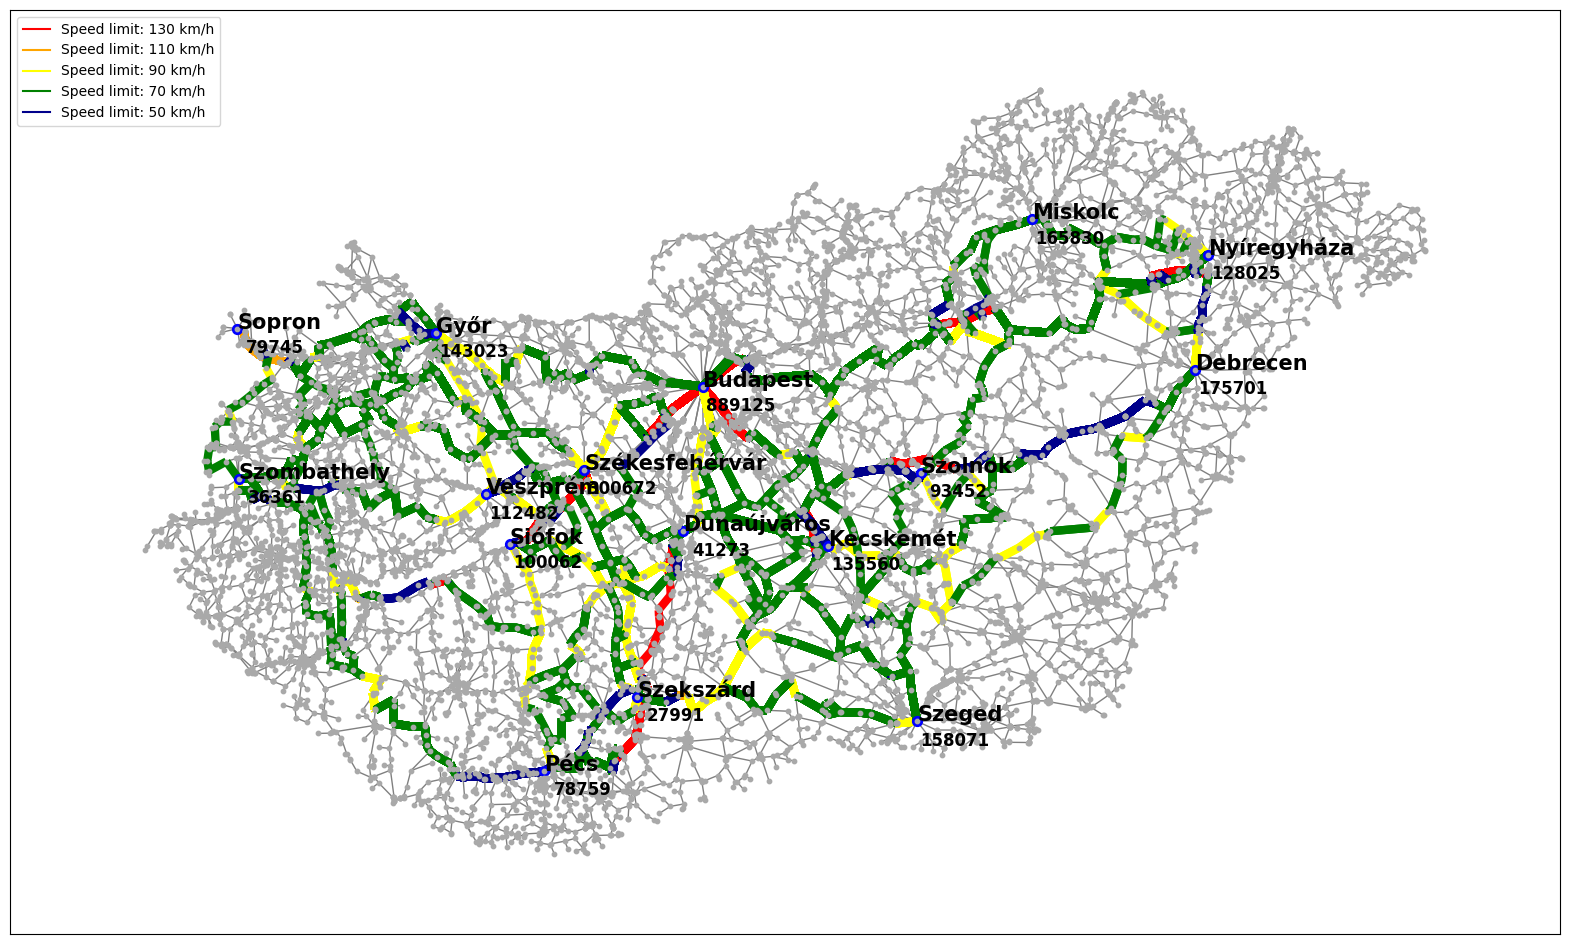

In [ ]:

import matplotlib.cm
import matplotlib.colors
import matplotlib.lines as mlines

color_map = matplotlib.colormaps.get_cmap('prism')
components = nx.connected_components(G)

plt.figure(figsize=(20, 12))

#Nodes
pos = {node: (attrs['x'], attrs['y']) for node, attrs in G.nodes(data=True)}
nx.draw_networkx(G, pos=pos, node_color='darkgrey', with_labels=False, edge_color='gray', node_size=10,)

#Coloring edges by speed
edges_by_color = {'red': [], 'orange': [], 'yellow': [], 'green': [], 'darkblue': []}
colors_speeds = {'red': 130, 'orange': 110, 'yellow': 90, 'green': 70, 'darkblue': 50}
for nodes, paths in extra['shortest_paths_dict'].items():
    for path in paths:
        edges = list(zip(path[:-1], path[1:]))  # Create a list of edges from the path
        for edge in edges:
            speed = G.get_edge_data(*edge)['speed']
            if speed == 130:
                color = 'red'
            elif speed == 110:
                color = 'orange'
            elif speed == 90:
                color = 'yellow'
            elif speed == 70:
                color = 'green'
            else:
                color = 'darkblue'
            edges_by_color[color].append(edge)

line_objects = [] #Save for the legend
for color, edges in edges_by_color.items():
    if edges:
        nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=color, width=6)
        line_objects.append(mlines.Line2D([], [], color=color, markersize=15, label=f'Speed limit: {colors_speeds[color]} km/h'))

#Location text
for node, attrs in G.nodes(data=True):
    if not attrs.get('ignore', True):
        edge_weight_sum = sum(data['weight'] for _, _, data in G.edges(node, data=True))
        plt.scatter(attrs['x'], attrs['y'], c='blue', s=50)
        plt.text(attrs['x'], attrs['y'], attrs['location_name'], fontsize=15,  weight='bold')
        plt.text(attrs['x']+15000, attrs['y'] - 10000, f'{edge_weight_sum}', fontsize=12, ha='center',  weight='bold')

plt.legend(handles=line_objects, loc='upper left')
plt.show()